# ニューラルネット実装

層が可変なコードを実装する。

neural_net_test_1での実装は以下のコード  
[ScratchSimpleNeuralNetworkClassifier]

```python
class ScratchSimpleNeuralNetworkClassifier():
    def __init__(self, verbose=True, lr=0.01, sigma=0.01):
        self.verbose = True
        self.batch_size = 10 # バッチサイズ
        self.n_features = 784 # 特徴量の数
        self.n_nodes1 = 400 # 1層目のノード数
        self.n_nodes2 = 200 # 2層目のノード数
        self.n_output = 10 # 出力のクラス数（3層目のノード数）
        self.sigma = 0.01 # ガウス分布の標準偏差
        self.lr = 0.1
        self.n_epoch = 5
        self.loss_list = []
        
        # それぞれの重み、バイアスの初期値
        self.w_1 = self.sigma * np.random.randn(n_features,n_nodes1)
        self.b_1 = self.sigma * np.random.randn(n_nodes1)
        self.w_2 = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        self.b_2 = self.sigma * np.random.randn(n_nodes2)
        self.w_3 = self.sigma * np.random.randn(n_nodes2, n_output)
        self.b_3 = self.sigma * np.random.randn(n_output)
    
    def fit(self, X_train, y_train): 
        get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=10)
        for epoch in range(10):
            print('epoch: {}'.format(epoch+1))
            for mini_X_train, mini_y_train in get_mini_batch:

                # forward
                # 1層目
                w_in_1 = np.dot(mini_X_train, self.w_1) + self.b_1
                out_1 = sigmoid(w_in_1) 

                # ２層目
                w_in_2 = np.dot(out_1, self.w_2) + self.b_2
                out_2 = sigmoid(w_in_2)

                # ３層目
                w_in_3 = np.dot(out_2, self.w_3) + self.b_3
                y_pred = softmax(w_in_3)

                # backpropagation
                # 3層目
                y_hat = y_pred - mini_y_train
                self.b_3 -= lr * np.mean(y_hat, axis=0)
                back_z2 = np.dot(y_hat, self.w_3.T)
                self.w_3 -= lr * np.dot(out_2.T, y_hat)/batch_size

                # 2層目
                back_a2 = back_z2 * (1-sigmoid(w_in_2)) * sigmoid(w_in_2) #(10,200)
                self.b_2 -= lr * np.mean(back_a2, axis=0)
                back_z1 = np.dot(back_a2, self.w_2.T)
                self.w_2 -= lr * np.dot(out_1.T, back_a2)/batch_size


                # 1層目
                back_a1 = back_z1 * (1-sigmoid(w_in_1)) * sigmoid(w_in_1) #(10,400)(10,400)
                self.b_1 -= lr * np.mean(back_a1, axis=0)
                self.w_1 -= lr * np.dot(mini_X_train.T, back_a1)/batch_size
                
            # lossの格納
            self.loss_list.append(cross_entropy(y_pred, mini_y_train))
                
    def predict(self, X):
        
        # forward
        # 1層目
        w_in_1 = np.dot(X, self.w_1) + self.b_1
        out_1 = sigmoid(w_in_1) 
        # ２層目
        w_in_2 = np.dot(out_1, self.w_2) + self.b_2
        out_2 = sigmoid(w_in_2)
        # ３層目
        w_in_3 = np.dot(out_2, self.w_3) + self.b_3
        y_pred = softmax(w_in_3)
        return y_pred
    
    def _softmax(self, X):
        if X.ndim == 2:
            X = X.T
            X = X - np.max(X, axis=0)
            y = np.exp(X) / np.sum(np.exp(X), axis=0)
            return y.T

        X = X - np.max(X)
        return np.exp(X) / np.sum(np.exp(X))

    def _sigmoid(self, X):
        return 1/(1+np.exp(-X))
    
    def _cross_entropy(self,y_pred, y_true):
        delta = 1e-7
        return -np.sum(y_true*np.log(y_pred+delta))
```

### 層が可変のニューラルネットクラス

In [5]:
import numpy as np
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from tqdm import trange
import time
%matplotlib inline

# 学習、予測クラス
class ScratchDeepNeuralNetworkClassifier():
    def __init__(self,n_features=784, n_nodes1=40, n_nodes2=20, n_output=10,
                 batch_size=100,epochs=20, sigma=0.1, lr=0.1, optimizer='SGD', initializer='simple'):
        self.batch_size = batch_size # バッチサイズ
        self.epochs = epochs #エポック数
        self.n_features = n_features # 特徴量の数
        self.n_nodes1 = n_nodes1 # 1層目のノード数
        self.n_nodes2 = n_nodes2 # 2層目のノード数
        self.n_output = n_output # 出力のクラス数（3層目のノード数）
        self.sigma = sigma # ガウス分布の標準偏差
        self.lr = lr #学習率
        self.ave_loss_list = np.empty(self.epochs)
        self.progres_loss_list = np.empty(self.epochs)
        
        # optimizerの設定
        if optimizer == 'SGD':
            self.optimizer = SGD(self.lr)
        elif optimizer == 'AdaGrad':
            self.optimizer = AdaGrad(self.lr)
            
        if initializer == 'simple':
            self.initializer = SimpleInitializer()
        elif initializer == 'xavier':
            self.initializer = XavierInitializer()
        elif initializer == 'he':
            self.initializer = HeInitializer()
        
        if (X_val is not None) and (y_val is not None):
            self.val_ave_loss_list = np.empty(self.epochs)

        
    
    def fit(self, X, y, X_val=None, y_val=None):
        self.FC1 = FC(self.n_features, self.n_nodes1, optimizer=self.optimizer, initializer=self.initializer)
        self.activation1 = Sigmoid()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, optimizer=self.optimizer, initializer=self.initializer)
        self.activation2 = Sigmoid()
        self.FC3 = FC(self.n_nodes2, self.n_output, optimizer=self.optimizer, initializer=self.initializer)
        self.activation3 = Softmax()
        
        with trange(self.epochs) as loop:
            for epoch in loop:
                loop.set_description("epoch")
                get_mini_batch = GetMiniBatch(X, y, self.batch_size)
                loss_list = np.empty(int(len(X)/self.batch_size))
                count_iter = 0

    #             if self.verbose == True:
    #                 get_mini_batch = tqdm(get_mini_batch)
    #                 get_mini_batch.set_description(f"epoch:{epoch+1}

                for mini_X_train, mini_y_train in get_mini_batch:

                    # フォワードプロパゲーション
                    y_pred = self.predict(mini_X_train)

                    #バックプロパゲーション
                    dA3 = self.activation3.backward(mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                    dZ2 = self.FC3.backward(dA3)
                    dA2 = self.activation2.backward(dZ2)
                    dZ1 = self.FC2.backward(dA2)
                    dA1 = self.activation1.backward(dZ1)
                    dZ0 = self.FC1.backward(dA1) # dZ0は使用しない

                    loss_list[count_iter]=self._cross_entropy(y_pred, mini_y_train)/mini_X_train.shape[0]
                    count_iter+=1
                count_iter = 0
                self.progres_loss_list[epoch]=self._cross_entropy(y_pred, mini_y_train)/mini_X_train.shape[0]
                self.ave_loss_list[epoch]=np.mean(loss_list)

                # validation用
                if (X_val is not None) and (y_val is not None):
                    y_val_pred =  self.predict(X_val)
                    self.val_ave_loss_list[epoch]=self._cross_entropy(y_val_pred, y_val)/X_val.shape[0]
            
    def predict(self, X):
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        return Z3
    
    def _cross_entropy(self, y_pred, y_true):
        delta = 1e-7
        return -np.sum(y_true*np.log(y_pred+delta))

# 全結合層クラス
class FC:
    
    def __init__(self, n_nodes1, n_nodes2, optimizer, initializer):
        self.optimizer = optimizer
        self.intializer = initializer
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.w = initializer.W(self.n_nodes1, self.n_nodes2)
        self.b = initializer.B(self.n_nodes1, self.n_nodes2)
        if isinstance(optimizer,AdaGrad):
            self.h_w = np.ones((self.n_nodes1, self.n_nodes2)) *1e-5
            self.h_b = np.ones((self.n_nodes2))*1e-5
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
    def forward(self, X):
        self.X = X
        self.affine = np.dot(X, self.w) + self.b
        return self.affine
    
    def backward(self, da):
        dz = np.dot(da, self.w.T)
        self.dw = np.dot(self.X.T, da)/da.shape[0]
        self.db = np.mean(da, axis=0)
        
        # 更新
        self = self.optimizer.update(self)
        return dz
    
# 初期化クラス
class SimpleInitializer:
    def __init__(self, sigma=0.1):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        W = self.sigma * np.random.randn(n_nodes1,n_nodes2)
        return W
    
    def B(self,n_nodes1, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B
    
class XavierInitializer(SimpleInitializer):
    def W(self, n_nodes1, n_nodes2):
        self.sigma = 1/np.sqrt(n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1,n_nodes2)
        return W
        
class HeInitializer(SimpleInitializer):
    def W(self, n_nodes1, n_nodes2):
        self.sigma = 1/np.sqrt(n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1,n_nodes2)
        return W
    
    
# 最適化クラス
class SGD:
    def __init__(self, lr=0.1):
        self.lr = lr
    def update(self, layer):
        layer.w -= self.lr * layer.dw
        layer.b -= self.lr * layer.db
        return layer
    
class AdaGrad:
    def __init__(self, lr=0.1):
        self.lr = lr
    def update(self, layer):
        layer.h_w += np.power(layer.dw, 2)
        layer.h_b += np.power(layer.db, 2)
        layer.w -= self.lr * layer.dw/np.sqrt(layer.h_w)
        layer.b -= self.lr * layer.db/np.sqrt(layer.h_b)
        return layer

#活性化関数層クラス
class Sigmoid:
    def forward(self, a):
        self.z = 1/(1+np.exp(-a))
        return self.z
    
    def backward(self, da):
        return da * (1-self.z) * self.z
        
    
class ReLu:
    def forward(self, Z):
         return np.maximum(0, Z)
    
    def backward(self, da):
        return np.where(da > 0, 1, 0)
        
class tanh:
    def forward(self, a):
        self.z = np.tanh(a)
        return self.z 
        
    def backward(self, da):
        return da * (1 - np.power(self.Z, 2))
        
class Softmax:
    def forward(self, a):
        if a.ndim == 2:
            a = a.T - np.max(a.T, axis=0)
            self.z = (np.exp(a) / np.sum(np.exp(a), axis=0)).T
            return self.z
        
        a = a - np.max(a)
        self.z = np.exp(a) / np.sum(np.exp(a))
        return self.z

        
    def backward(self, y):
        return self.z - y



## データの読み込み、前処理

In [6]:
# mnistの読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 平滑化
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# floatに変換
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)

# 正規化
X_train /= 255
X_test /= 255

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)


# ミニバッチを取得するクラス
class GetMiniBatch:
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

(60000,)
(60000, 10)
float64
(48000, 784)
(12000, 784)


In [7]:
def learning_plot(clf):
    plt.plot(clf.progres_loss_list, label='train', marker='o')
    plt.plot(clf.val_ave_loss_list, label='test', marker='o')
    plt.title('train and val loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend();

## 最適化手法と初期値を複数試す

epoch: 100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


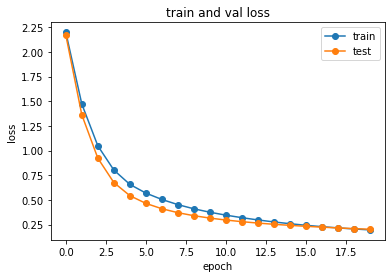

In [8]:
clf1=ScratchDeepNeuralNetworkClassifier(optimizer='SGD', initializer='simple')
clf1.fit(X_train, y_train, X_val, y_val)
learning_plot(clf1)

epoch: 100%|██████████| 20/20 [00:11<00:00,  1.76it/s]


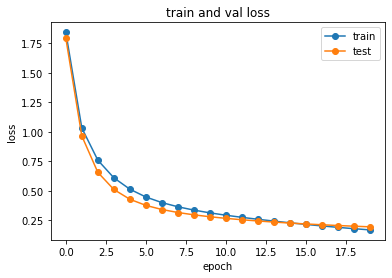

In [9]:
clf2=ScratchDeepNeuralNetworkClassifier(optimizer='SGD', initializer='xavier')
clf2.fit(X_train, y_train, X_val, y_val)
learning_plot(clf2)

epoch: 100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


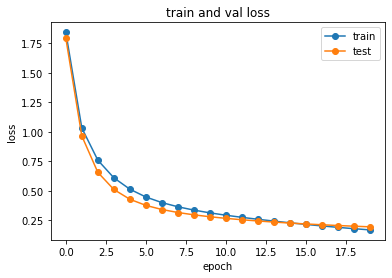

In [10]:
clf3=ScratchDeepNeuralNetworkClassifier(optimizer='SGD', initializer='he')
clf3.fit(X_train, y_train, X_val, y_val)
learning_plot(clf3)

epoch: 100%|██████████| 20/20 [00:23<00:00,  1.18s/it]


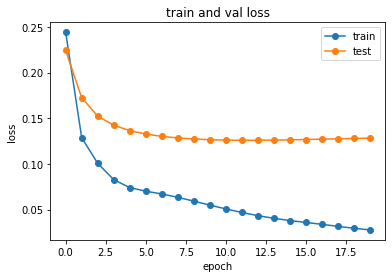

In [19]:
clf4=ScratchDeepNeuralNetworkClassifier(optimizer='AdaGrad', initializer='simple')
clf4.fit(X_train, y_train, X_val, y_val)
learning_plot(clf4)

epoch: 100%|██████████| 20/20 [00:21<00:00,  1.06s/it]


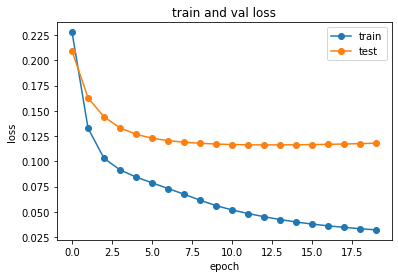

In [20]:
clf5=ScratchDeepNeuralNetworkClassifier(optimizer='AdaGrad', initializer='xavier')
clf5.fit(X_train, y_train, X_val, y_val)
learning_plot(clf5)

epoch: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


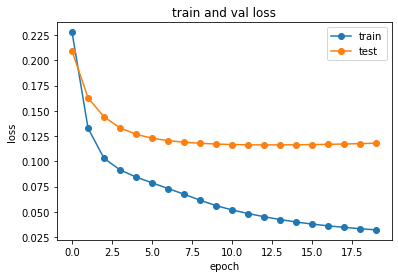

In [21]:
clf6=ScratchDeepNeuralNetworkClassifier(optimizer='AdaGrad', initializer='he')
clf6.fit(X_train, y_train, X_val, y_val)
learning_plot(clf6)

## FC層の作成

In [2]:
class FC:
    
    def __init__(self, n_nodes1, n_nodes2, optimizer, initializer):
        self.optimizer = optimizer
        self.intializer = initializer
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.w = initializer.W(self.n_nodes1, self.n_nodes2)
        self.b = initializer.B(self.n_nodes1, self.n_nodes2)
        if isinstance(optimizer,AdaGrad):
            self.h_w = np.ones((self.n_nodes1, self.n_nodes2)) *1e-5
            self.h_b = np.ones((self.n_nodes2))*1e-5
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
    def forward(self, X):
        self.X = X
        self.affine = np.dot(X, self.w) + self.b
        return self.affine
    
    def backward(self, da):
        dz = np.dot(da, self.w.T)
        self.dw = np.dot(self.X.T, da)/da.shape[0]
        self.db = np.mean(da, axis=0)
        
        # 更新
        self = self.optimizer.update(self)
        return dz

## 初期化方法クラス

class SimpleInitializer:
    def __init__(self, sigma=0.1):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        W = self.sigma * np.random.randn(n_nodes1,n_nodes2)
        return W
    
    def B(self,n_nodes1, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B
    
class XavierInitializer(SimpleInitializer):
    def W(self, n_nodes1, n_nodes2):
        self.sigma = 1/np.sqrt(n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1,n_nodes2)
        return W
        
class HeInitializer(SimpleInitializer):
    def W(self, n_nodes1, n_nodes2):
        self.sigma = 1/np.sqrt(n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1,n_nodes2)
        return W

## 最適化クラス

In [5]:
class SGD:
    def __init__(self, lr=0.1):
        self.lr = lr
    def update(self, layer):
        layer.w -= self.lr * layer.dw
        layer.b -= self.lr * layer.db
        return layer
    
class AdaGrad:
    def __init__(self, lr=0.1):
        self.lr = lr
    def update(self, layer):
        layer.h_w += np.power(layer.dw, 2)
        layer.h_b += np.power(layer.db, 2)
        layer.w -= self.lr * layer.dw/np.sqrt(layer.h_w)
        layer.b -= self.lr * layer.db/np.sqrt(layer.h_b)
        return layer

## 活性化関数のクラス

In [6]:
class Sigmoid:
    def forward(self, a):
        self.z = 1/(1+np.exp(-a))
        return self.z
    
    def backward(self, da):
        return da * (1-self.z) * self.z
        
    
class ReLu:
    def forward(self, Z):
         return np.maximum(0, Z)
    
    def backward(self, da):
        return np.where(da > 0, 1, 0)
        
class tanh:
    def forward(self, a):
        self.z = np.tanh(a)
        return self.z 
        
    def backward(self, da):
        return da * (1 - np.power(self.Z, 2))
        
class Softmax:
    def forward(self, a):
        if a.ndim == 2:
            a = a.T - np.max(a.T, axis=0)
            self.z = (np.exp(a) / np.sum(np.exp(a), axis=0)).T
            return self.z
        
        a = a - np.max(a)
        self.z = np.exp(a) / np.sum(np.exp(a))
        return self.z

        
    def backward(self, y):
        return self.z - y

In [ ]:
# def _cross_entropy(y_pred, y_true):
#         delta = 1e-7
#         return -np.sum(y_true*np.log(y_pred+delta))

## 学習

In [ ]:
epochs = 10
get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=10)
ave_loss_list = np.empty(epochs)


for epoch in range(epochs):
    loss_list = np.empty(int(len(X_train)/batch_size))
    count_iter = 0
    for mini_X_train, mini_y_train in get_mini_batch:
        A1 = FC1.forward(mini_X_train)
        Z1 = activation1.forward(A1)
        A2 = FC2.forward(Z1)
        Z2 = activation2.forward(A2)
        A3 = FC3.forward(Z2)
        Z3 = activation3.forward(A3)

        dA3 = activation3.backward(mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
        dZ2 = FC3.backward(dA3)
        dA2 = activation2.backward(dZ2)
        dZ1 = FC2.backward(dA2)
        dA1 = activation1.backward(dZ1)
        dZ0 = FC1.backward(dA1) # dZ0は使用しない
        loss_list[count_iter]=_cross_entropy(Z3, mini_y_train)
        count_iter+=1
    count_iter = 0
    ave_loss_list[epoch]=np.mean(loss_list)
    print(f'epoch: {epoch+1}')

## 予測

In [ ]:
A1 = FC1.forward(X_train)
Z1 = activation1.forward(A1)
A2 = FC2.forward(Z1)
Z2 = activation2.forward(A2)
A3 = FC3.forward(Z2)
Z3 = activation3.forward(A3)

print(f"10枚の画像のラベルの予測結果:{np.argmax(Z3[0:11],axis=1)}")
print(f"10枚の画像のラベルの正解:{np.argmax(y_train[0:11],axis=1)}")

## クラス化

In [14]:
class ScratchDeepNeuralNetworkClassifier():
    def __init__(self,n_features=784, n_nodes1=40, n_nodes2=20, n_output=10,
                 batch_size=100,epochs=20, sigma=0.1, lr=0.1, optimizer='SGD', initializer='simple'):
        self.batch_size = batch_size # バッチサイズ
        self.epochs = epochs #エポック数
        self.n_features = n_features # 特徴量の数
        self.n_nodes1 = n_nodes1 # 1層目のノード数
        self.n_nodes2 = n_nodes2 # 2層目のノード数
        self.n_output = n_output # 出力のクラス数（3層目のノード数）
        self.sigma = sigma # ガウス分布の標準偏差
        self.lr = lr #学習率
        self.ave_loss_list = np.empty(self.epochs)
        self.progres_loss_list = np.empty(self.epochs)
        
        # optimizerの設定
        if optimizer == 'SGD':
            self.optimizer = SGD(self.lr)
        elif optimizer == 'AdaGrad':
            self.optimizer = AdaGrad(self.lr)
            
        if initializer == 'simple':
            self.initializer = SimpleInitializer()
        elif initializer == 'xavier':
            self.initializer = XavierInitializer()
        elif initializer == 'he':
            self.initializer = HeInitializer()
        
        if (X_val is not None) and (y_val is not None):
            self.val_ave_loss_list = np.empty(self.epochs)

        
    
    def fit(self, X, y, X_val=None, y_val=None):
        self.FC1 = FC(self.n_features, self.n_nodes1, optimizer=self.optimizer, initializer=self.initializer)
        self.activation1 = Sigmoid()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, optimizer=self.optimizer, initializer=self.initializer)
        self.activation2 = Sigmoid()
        self.FC3 = FC(self.n_nodes2, self.n_output, optimizer=self.optimizer, initializer=self.initializer)
        self.activation3 = Softmax()
        
        
        for epoch in range(self.epochs):
            get_mini_batch = GetMiniBatch(X, y, self.batch_size)
            loss_list = np.empty(int(len(X)/self.batch_size))
            count_iter = 0
            gbatch = tqdm(get_mini_batch)
            gbatch.set_description(f"epoch:{epoch+1}")
            for mini_X_train, mini_y_train in gbatch:
                
                # フォワードプロパゲーション
                y_pred = self.predict(mini_X_train)
                
                #バックプロパゲーション
                dA3 = self.activation3.backward(mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
                
                loss_list[count_iter]=self._cross_entropy(y_pred, mini_y_train)/mini_X_train.shape[0]
                count_iter+=1
            count_iter = 0
            self.progres_loss_list[epoch]=self._cross_entropy(y_pred, mini_y_train)/mini_X_train.shape[0]
            self.ave_loss_list[epoch]=np.mean(loss_list)
            
            # validation用
            if (X_val is not None) and (y_val is not None):
                y_val_pred =  self.predict(X_val)
                self.val_ave_loss_list[epoch]=self._cross_entropy(y_val_pred, y_val)/X_val.shape[0]
#                 print(self._cross_entropy(y_val_pred, y_val)/X_val.shape[0])
                
#             print(f'epoch: {epoch+1}')
            
    def predict(self, X):
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        return Z3
    
    def _cross_entropy(self, y_pred, y_true):
        delta = 1e-7
        return -np.sum(y_true*np.log(y_pred+delta))
        

In [15]:
clf=ScratchDeepNeuralNetworkClassifier(batch_size=100, epochs=20, n_features = 784, n_nodes1 = 40, n_nodes2 = 20,n_output = 10)
clf.fit(X_train, y_train, X_val, y_val)

epoch:20: 100%|██████████| 480/480 [00:00<00:00, 1151.11it/s]


In [16]:
np.argmax(clf.predict(X_train[0:10]),axis=1)

array([8, 5, 9, 0, 3, 7, 9, 2, 2, 1])

In [17]:
np.argmax(y_train[0:10],axis=1)

array([8, 3, 9, 0, 3, 7, 9, 2, 2, 1])

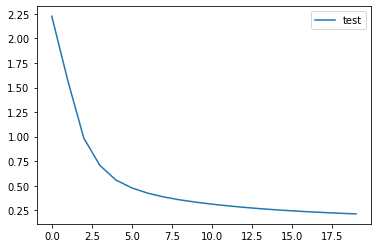

In [18]:
plt.plot(clf.val_ave_loss_list, label='test');
plt.legend();

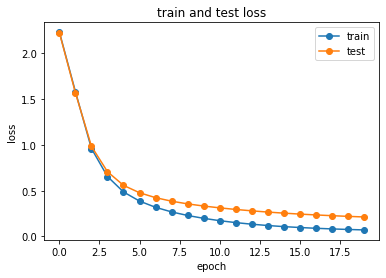

In [19]:
plt.plot(clf.progres_loss_list, label='train', marker='o')
plt.plot(clf.val_ave_loss_list, label='test', marker='o')
plt.title('train and test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend();